<a href="https://colab.research.google.com/github/JBOWLN2/Coursera_Capstone/blob/master/TorontoNeighborhoodClusteringpart3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:

import numpy as np
from numpy import mean
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 

!pip install geopy
import geopy as gp
from geopy.geocoders import Nominatim


import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup

import xml

!pip install folium
import folium

# Evaluation and plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

print('Success!')

Success!


### Scrap data from wikipedia

In [0]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url,'lxml')

In [76]:
table_post = soup.find('table')
fields = table_post.find_all('td')

postcode = []
borough = []
neighbourhood = []

for i in range(0, len(fields), 3):
    postcode.append(fields[i].text.strip())
    borough.append(fields[i+1].text.strip())
    neighbourhood.append(fields[i+2].text.strip())
        
df = pd.DataFrame(data=[postcode, borough, neighbourhood]).transpose()
df.columns = ['Postcode', 'Borough', 'Neighbourhood']
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Remove cells with "unassigned"

In [77]:
df['Borough'].replace('Not assigned', np.nan, inplace=True)
df.dropna(subset=['Borough'], inplace=True)

df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Combine neighborhood with same postcode

In [78]:
df = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df.columns = ['Postcode', 'Borough', 'Neighbourhood']
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Dealing with queens park
"If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park."


In [79]:
df['Neighbourhood'].replace('Not assigned', "Queen's Park", inplace=True)
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [80]:
df.shape

(103, 3)

### Import lat long csv and merge

In [81]:
df2 = pd.read_csv('http://cocl.us/Geospatial_data')
df2.columns = ['Postcode', 'Latitude', 'Longitude']
df2.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [82]:
df3 = pd.merge(df, df2, on=['Postcode'], how='inner')
df = df3[['Borough', 'Neighbourhood', 'Postcode', 'Latitude', 'Longitude']].copy()
df.head()

,Borough,Neighbourhood,Postcode,Latitude,Longitude
0,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,Scarborough,Woburn,M1G,43.770992,-79.216917
4,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


In [83]:
df.shape

(103, 5)

### Get Toronoto lat and long

In [84]:
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="jbowling@g.harvard.edu")
location = geolocator.geocode(address)
lat = location.latitude
long = location.longitude
print('The latitude and longitude of Toronto is {}, {}.'.format(lat, long))

The latitude and longitude of Toronto is 43.653963, -79.387207.


### Create a map of toronto and add markers (borrowed from prior exercises for NYC)

In [0]:
toronto_map = folium.Map(location=[lat, long], zoom_start=10.5)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(toronto_map)  

### Display map

In [86]:
toronto_map

## Clustering Analysis

I tried several different number of clusters, starting with five, I then tried four. Five created the most distinct clusters. I also used min and max zoom to make it easier to visualize at different zoom levels without accidentally zooming back and forth so far that it becomes meaningless. Try scrolling to zoom and you will see it doesn't zoom you way out or way in to where you get disoriented. Lasly, I filled in the dots to get rid of the border illusion and provide a more reader friendly view. I borrowed many concepts and lines from the New York lab and altered them to fit this specific example.

In [128]:
toronto_map = folium.Map(location=[lat, long], zoom_start=10.5, min_zoom=9, max_zoom=11.5)

X = df['Latitude']
Y = df['Longitude']
y = np.stack((X, Y), axis=1)

km = KMeans(n_clusters=5, random_state=0).fit(y)

clusters = km.labels_
colors = ['blue', 'black', 'red', 'green', 'white']
df['Cluster'] = clusters

for latitude, longitude, borough, cluster in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Cluster']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 4,
        popup = label,
        color = colors[cluster],
        fill = True,
        fill_color = colors[cluster],
        fill_opacity=1).add_to(toronto_map)  

toronto_map

In [150]:
#Further analysis and parameter tuning experiments
toronto_map = folium.Map(location=[lat, long], zoom_start=10.5, min_zoom=9, max_zoom=11)

X2 = df['Latitude']
Y2 = df['Longitude']
y2 = np.stack((X2, Y2), axis=1)

km2 = KMeans(n_clusters=4, max_iter=500).fit(y2)

clusters = km2.labels_
colors = ['blue', 'black', 'red', 'green', 'white', 'orange', 'yellow']
df['Cluster'] = clusters

for latitude, longitude, borough, cluster in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Cluster']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 4,
        popup = label,
        color = colors[cluster],
        fill = True,
        fill_color = colors[cluster],
        fill_opacity=1).add_to(toronto_map)  

toronto_map

## Evaluation

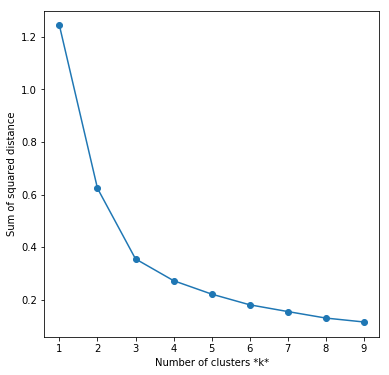

In [118]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(y)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

## Conclusion
Ultimately, it looks like 3-4 clusters might be the best K considering the evaluation analyzing it with SSE, but since my goal was to distingusih buroughs, and the elbow is not very distinct, I think 5 is a better result.

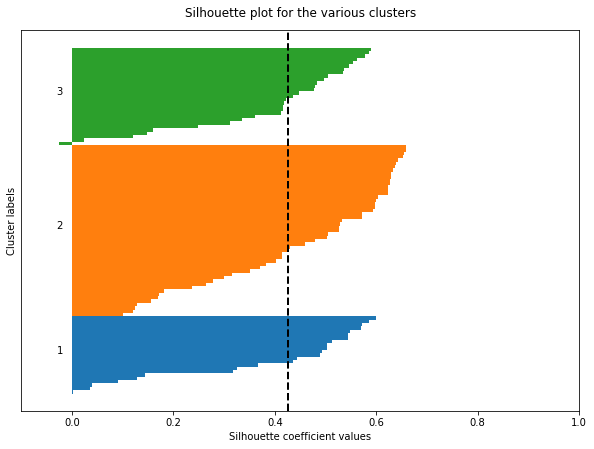

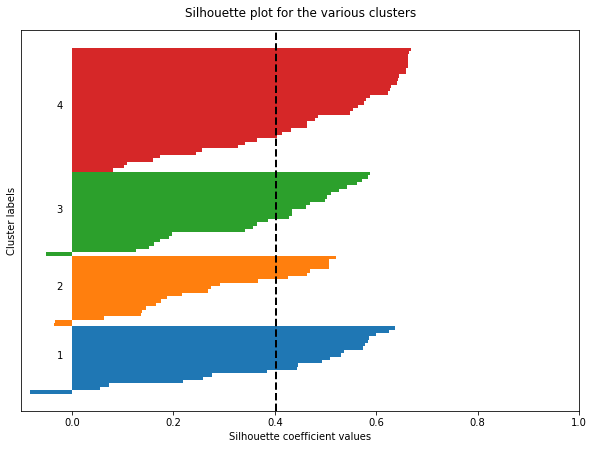

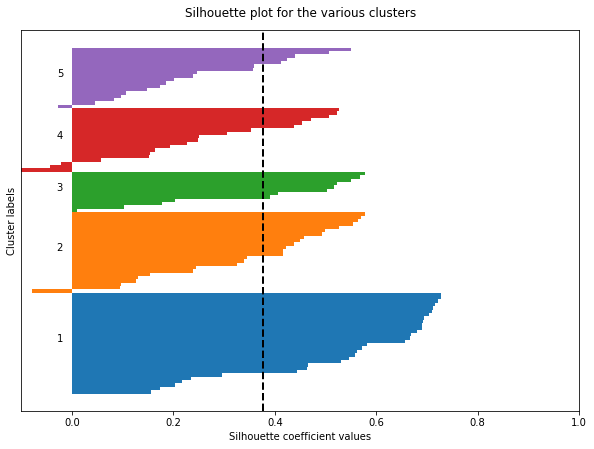

In [152]:
#km = KMeans(n_clusters=5, random_state=0).fit(y)
#clusters = km.labels_

for i, k in enumerate([3, 4, 5]):
    fig = plt.figure()
    fig.set_size_inches(10, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(y)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(y, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        plt.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax = fig.gca()
    ax.axvline(avg_score, linestyle='--', linewidth=2, color='black')
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    ax.set_xlabel('Silhouette coefficient values')
    ax.set_ylabel('Cluster labels')
    ax.set_title('Silhouette plot for the various clusters', y=1.02);

